https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values

In [2]:
!pip install torch

     -------------------------------------- 226.6/226.6 MB 5.3 MB/s eta 0:00:00


In [8]:

#!pip install wget 

import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns

In [9]:
# Fix the seed ------------------------------------------------------
np.random.seed(0)

In [10]:
# Sample data generation ------------------------------------------------------
# Generate complete data

n = 100
p = 2

mu_X = np.repeat(1, p)
Sigma_X = np.array([[1, 1], [1, 4]])
X_complete_cont = np.random.multivariate_normal(mu_X, Sigma_X, size=n)

from scipy.stats import poisson

lamb = 0.5
X_complete_discr = poisson.rvs(lamb, size=n)
X_complete_discr = np.expand_dims(X_complete_discr, axis=1)


n_cat = 5
X_complete_cat = np.random.binomial(n=n_cat, p=0.5, size=n)
X_complete_cat = np.expand_dims(X_complete_cat, axis=1)

X_complete = np.concatenate((X_complete_cont, X_complete_discr, X_complete_cat),axis=1)

X_complete = pd.DataFrame(X_complete)
X_complete.iloc[:, 3] = X_complete.iloc[:, 3].astype('category')
X_complete.iloc[:, 3].cat.categories = ["F", "E", "D", "C", "B", "A"]
X_complete.head()

,0,1,2,3
0,2.380172,4.405363,1.0,F
1,3.379180,2.400869,0.0,D
2,1.341582,4.944151,0.0,E
3,1.450141,2.922843,0.0,D
4,1.266093,0.695726,2.0,D


In [13]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [14]:
# Minimal example for generating missing data ------------------------
X_miss_mcar = produce_NA(X_complete_cont, p_miss=0.4, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of newly generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

Percentage of newly generated missing values:  39.0  %


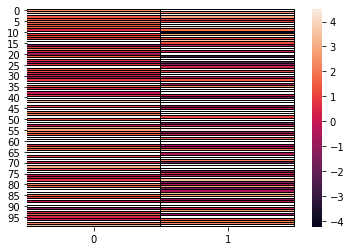

In [15]:
ax = sns.heatmap(X_mcar, mask=R_mcar.numpy()==1, linewidths=0.005, linecolor='black')

Percentage of generated missing values:  20.5  %


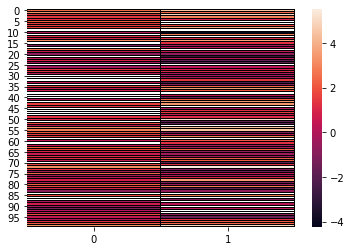

In [26]:
# Sample mcar data -----------------------------------------
X_miss_mcar = produce_NA(X_complete_cont, p_miss=0.2, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

ax = sns.heatmap(X_mcar, mask=R_mcar.numpy()==1, linewidths=0.005, linecolor='black')

In [24]:
X_complete_cont.shape

(100, 2)

In [25]:
X_mcar.shape

torch.Size([100, 2])